# Word2Vec Analysis

This file conducts Word2Vec Analysis on our data.

In [34]:
import pandas as pd
import numpy as np
from scipy.linalg import norm, eigh
from sklearn.decomposition import PCA
import plotly_express as px
from scipy.linalg import eigh
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px
from gensim.models import word2vec
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [35]:
data_in = "./data"

In [36]:
CORPUS = pd.read_csv(data_in+"/CORPUS.csv").drop("Unnamed: 0", axis=1).set_index(['source', 'text_num', 'para_num', 'sent_num', 'token_num'])
LIB = pd.read_csv(data_in+"/LIB.csv").set_index("source_id")
VOCAB = pd.read_csv(data_in+"/VOCAB.csv").set_index("term_str")

In [23]:
OHCO = ['source', 'text_num', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:4]
PARAS = OHCO[:3]
ARTICLES = OHCO[:2]
SOURCES = OHCO[:1]

In [24]:
noun_verb_tags = ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

In [25]:
TOKENS = CORPUS[CORPUS.pos.isin(noun_verb_tags)]
TOKENS.head()

pos_tuple  pos  \
source text_num para_num sent_num token_num                               
CNN    0        0        0        2             ('infants', 'NNS')  NNS   
                                  3                ('have', 'VBP')  VBP   
                                  4          ('contracted', 'VBN')  VBN   
                                  6              ('herpes', 'NNS')  NNS   
                                  7                ('virus', 'NN')   NN   

                                              token_str    term_str  
source text_num para_num sent_num token_num                          
CNN    0        0        0        2             infants     infants  
                                  3                have        have  
                                  4          contracted  contracted  
                                  6              herpes      herpes  
                                  7               virus       virus

In [26]:
VOCAB = TOKENS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
# get the most frequently associated part-of-space category for each word.
VOCAB['max_pos'] = TOKENS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['pos_group'] = VOCAB['max_pos'].apply(lambda x: x[:2])

In [27]:
VOCAB.head()

,n,max_pos,pos_group
term_str,,,
1800s,1,NNS,NN
1950s,1,NNS,NN
1960s,2,NNS,NN
1970s,5,NNS,NN
1980s,2,NNS,NN


In [28]:
BAG = ARTICLES

In [14]:
# convert to DOCS for Gensim
DOCS = TOKENS.groupby(BAG)\
    .term_str.apply(lambda x: x.tolist())\
    .reset_index()['term_str'].tolist()

Using a previously written class for analysis.

In [45]:
CORPUS = CORPUS.reset_index()

In [46]:
CNN = CORPUS[CORPUS["source"] == "CNN"]
CNBC = CORPUS[CORPUS["source"] == "CNBC"]

In [29]:
class gensim_corpus():
    
    def __init__(self, TOKENS, BAG):
        
        self.tokens = TOKENS
        self.docs = TOKENS.groupby(BAG).term_str.apply(lambda  x:  x.tolist()).reset_index()['term_str'].tolist()
        self.docs = [doc for doc in self.docs if len(doc) > 1]
        
        self.vocab = TOKENS.term_str.value_counts().to_frame('n').sort_index()
        self.vocab.index.name = 'term_str'
        self.vocab["pos_group"] = TOKENS[['term_str', 'pos']].value_counts().unstack(fill_value = 0)\
        .idxmax(1).str[:2]
        self.vocab["log(freq)"] = np.log(self.vocab.n)
        
    def word2vec(self, min_count, window = 2, vector_size = 256):
        # word2vec parameters
        #w2v_params = dict(
        #    window = 5,
        #    size = 246,
        #    min_count = 50,
        #    workers = 4)
        self.model = word2vec.Word2Vec(self.docs, 
                                       min_count = min_count,
                                       window = window,
                                       vector_size = vector_size,
                                       workers = 4)#**w2v_params)
        
    def generate_coords(self,learning_rate = 200.,
                        perplexity = 20,
                        n_components = 2,
                        init = 'random',
                        n_iter = 1000,
                        random_state = 42):
        self.coords = pd.DataFrame(dict(
            vector = [self.model.wv.get_vector(w) for w in self.model.wv.key_to_index], 
            term_str = self.model.wv.key_to_index.keys()
        )).set_index('term_str')
        
        tsne_engine = TSNE(perplexity=perplexity, n_components=n_components, init=init,\
                           n_iter=n_iter, random_state=random_state, learning_rate=learning_rate)
        tsne_model = tsne_engine.fit_transform(np.array(self.coords.vector.to_list()))
        
        self.coords['x'] = tsne_model[:,0] 
        self.coords['y'] = tsne_model[:,1]
        
        if self.coords.shape[1] == 3:
            self.coords = self.coords.merge(self.vocab.reset_index(), on='term_str')
            self.coords = self.coords.set_index('term_str')
                
        
    def plot(self):
        figure = px.scatter(self.coords.reset_index(), 'x', 'y', 
                            text='term_str', 
                            color='pos_group', 
                            hover_name='term_str',          
                            size='log(freq)',
                            height=800).update_traces(
            mode='markers+text', 
            textfont=dict(color = 'black', size=14, family='Arial'),
            textposition='top center')
        return figure
        
    def complete_analogy(self, A, B, C, n=8):
        try:
            cols = ['term', 'sim']
            return pd.DataFrame(self.model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
            
        except KeyError as e:
            print('Error:', e)
            return None
    
    def get_most_similar(self, positive, negative=None):
                                return pd.DataFrame(self.model.wv.most_similar(positive, negative), \
                                                    columns=['term', 'sim'])
                            
                                    
                                    

In [48]:
CNN_gensim = gensim_corpus(CNN, PARAS)

In [49]:
CNN_gensim.word2vec(min_count = 50)
CNN_gensim.generate_coords()

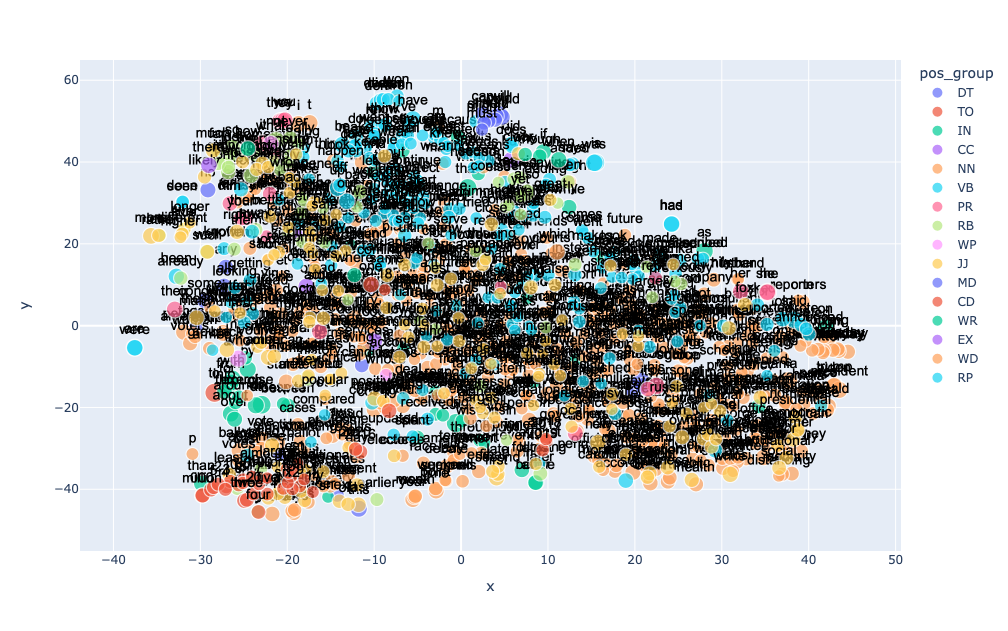

In [50]:
CNN_gensim.plot().show()

In [51]:
CNBC_gensim = gensim_corpus(CORPUS, PARAS)

In [52]:
CNBC_gensim.word2vec(min_count = 50)
CNBC_gensim.generate_coords()

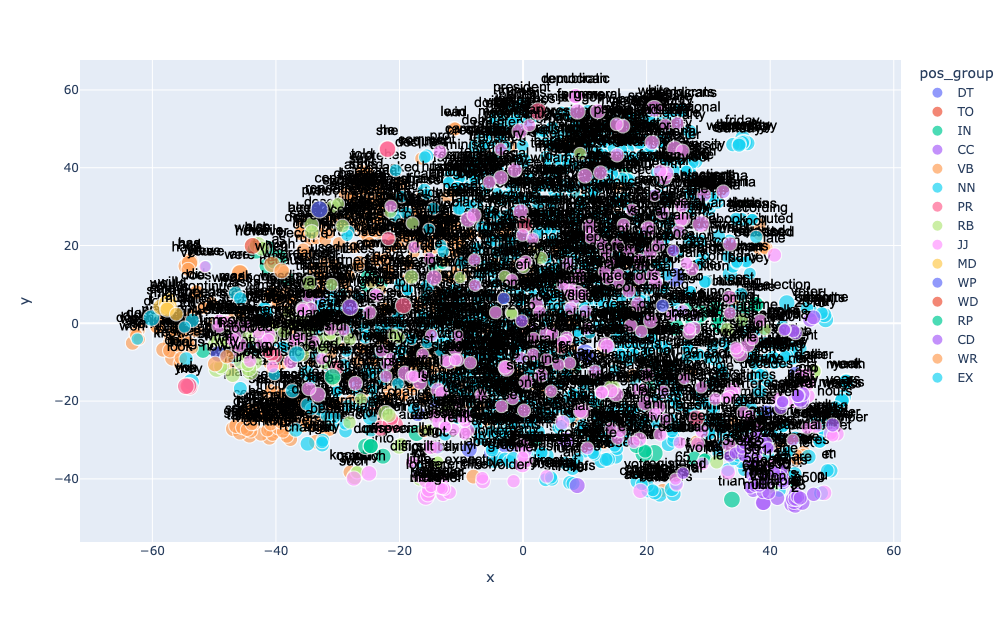

In [53]:
CNBC_gensim.plot().show()

In [54]:
CNN_gensim.get_most_similar("trump")

,term,sim
0,biden,0.860657
1,pence,0.783681
2,president,0.765098
3,barr,0.718398
4,himself,0.705618
5,harris,0.692974
6,running,0.674829
7,obama,0.669761
8,fox,0.667758
9,kamala,0.649452


In [55]:
CNBC_gensim.get_most_similar("trump")

,term,sim
0,pence,0.757725
1,obama,0.687855
2,biden,0.674829
3,barr,0.663307
4,trumps,0.648268
5,bidens,0.638223
6,president,0.634999
7,harris,0.621577
8,mccarthy,0.613487
9,clinton,0.586992


In [56]:
CNN_gensim.get_most_similar("republican")

,term,sim
0,democratic,0.910116
1,gop,0.889945
2,sen,0.886193
3,former,0.884444
4,senior,0.873825
5,adviser,0.872612
6,deputy,0.860266
7,party,0.852887
8,led,0.849263
9,arizona,0.844655


In [57]:
CNBC_gensim.get_most_similar("republican")

,term,sim
0,democratic,0.908340
1,gop,0.837599
2,sen,0.809491
3,party,0.808814
4,conservative,0.790458
5,rep,0.789161
6,former,0.780243
7,democrat,0.771897
8,arizona,0.763900
9,congressional,0.755625


In [58]:
CNN_gensim.get_most_similar("win")

,term,sim
0,lead,0.855081
1,pick,0.850314
2,attempt,0.844805
3,show,0.834110
4,effort,0.834035
5,change,0.834010
6,stage,0.818592
7,winner,0.814568
8,begin,0.801315
9,leading,0.796876


In [59]:
CNBC_gensim.get_most_similar("win")

,term,sim
0,lead,0.839360
1,victory,0.817837
2,accept,0.808483
3,joe,0.761159
4,pick,0.754961
5,attempt,0.735542
6,presidency,0.733934
7,favor,0.726776
8,delay,0.710069
9,claim,0.690376


In [62]:
CNN_gensim.complete_analogy(A = 'trump', B = 'win', C = 'biden')

,term,sim
0,change,0.777674
1,pick,0.743877
2,stage,0.733227
3,lead,0.731046
4,winner,0.726967
5,race,0.718226
6,leading,0.705421
7,joe,0.704926


In [63]:
CNBC_gensim.complete_analogy(A = 'trump', B = 'win', C = 'biden')

,term,sim
0,victory,0.655278
1,lead,0.653861
2,vote,0.613085
3,pick,0.609869
4,nominee,0.608867
5,accept,0.594004
6,joe,0.590920
7,favor,0.561618
